# tScanner
A RSA Public Key Scanner

## Web Mining Final Project
### Daiwei Chen

This project is to go alongside of [Tetanus](https://github.com/ForeverAnApple/Tetanus), the Batch GCD RSA Weak Keys cracker. The purpose of this tool is to obtain public keys from SSL certificates (SSH, PGP may come later). The other point of this tool is to format the RSA keys correctly to extract the modulus of each key to insert into Tetanus for further analysis.

# Certificate Scanning Stage
First, a random amount of IPs will be generated in order to attempt a port 443 SSL handshake to obtain the server certificate. The certificates will be stored for furture public key and public key modulus extraction at a later stage.

During the certificate scanning stage, this slice of code will attempt to perform a socket connection to the given ip. With a default timeout of 10 seconds. Since all the ips are randomly generated, we will not be sure that the IP has a running webserver on 443 with HTTPS. The code will reflect on that and continue to test new generated IPs until it reaches the VALID_CERTS limit.

I've also obtained a list of hostnames from rapid7 labs open data to scan through to look for certificates. The code will look out for already scanned hosts and skip if needed.

This code was ran outside of the ipynb as it is very network and time heavy.

For now, about 10000 certificates will be scanned for info extraction.

In [98]:
import ssl
import sys
import time
import random
import pickle
import os
from socket import *
from cryptography import x509
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.serialization import PublicFormat
from cryptography.hazmat.primitives.serialization import Encoding
from random import getrandbits
from ipaddress import IPv4Address

random.seed(time.time())

# Load the dictionary, if possible
if os.path.exists(os.path.join(os.getcwd(), 'scanned_certs.pkl')):
    with open('scanned_certs.pkl', 'rb') as f:
        certs = pickle.load(f)
else:
    certs = dict()

# Load the set of already tried IPs
if os.path.exists(os.path.join(os.getcwd(), 'scanned_ips.pkl')):
    with open('scanned_ips.pkl', 'rb') as f:
        scannedIps = pickle.load(f)
else:
    scannedIps = set()

print("Loaded", len(certs), "certificate(s) and", len(scannedIps), "scanned IPs.")

VALID_CERTS = 100
print("Attempting to scan for", VALID_CERTS, "valid certificate(s).")

setdefaulttimeout(2) # time is of the essence

i = len(certs)
tries = 0
successful = 0

start = time.time()

def scanIP(ip):
    global i, tries, successful
    try:                                                                                                              
        cert = ssl.get_server_certificate((ip, 443))
    except (error, timeout) as err:
      cert = "Timed Out"

    if cert != "Timed Out":
        certs[ip] = cert
        #print("Certificate extracted from", ip)
        successful += 1
        i += 1
        with open("scanned_certs.pkl", 'wb') as f:
            pickle.dump(certs, f)
    
        with open("scanned_ips.pkl", 'wb') as f:
            pickle.dump(scannedIps, f)
            
    else:
        #print(ip, "timed out")
        pass

# Randomly Generate IPs and attempt to obtain a valid SSL 
# certificate off of them
while i < VALID_CERTS:
    tries += 1
    bits = getrandbits(32)
    addr = IPv4Address(bits)
    addr_str = str(addr)
    #print("Trying", addr_str)
    if addr_str not in scannedIps:
        scannedIps.add(addr_str)
        scanIP(addr_str)

# This is true within the real scanning code
if True:
    print("Scanning from hostnames file")
    with open('hostnames_443') as f:
        hostnames = f.readlines()

    hostnames = [h.rstrip('\n') for h in hostnames]

    for name in hostnames:
        if name not in scannedIps and len(name) < 64:
            scannedIps.add(name)
            scanIP(name)
                
        if len(certs) >= 10000:
            break
    
            
#print(certs)
print("Tried", tries, "ips for", successful, "successful certificate extractions.")
end = time.time()
print("Scanning for", successful, "valid certificates took", (end-start)/60, "minutes")
print("Total Scanned Certificates:", len(certs))

Loaded 12000 certificate(s) and 33166 scanned IPs.
Attempting to scan for 100 valid certificate(s).
Scanning from hostnames file
Tried 0 ips for 0 successful certificate extractions.
Scanning for 0 valid certificates took 0.004876033465067545 minutes
Total Scanned Certificates: 12000


# Public Key Extraction
Next, we proceed to extract the public key from the certificate, as well as extracting the public components n (modulus) and e. This information will be saved onto a text file in hex form as to send to Tetanus for furthur analysis.

## Duplicate Public Keys
The Batch-GCD function is giving false positives due to certificates using the same RSA Public Key. I will attempt to filter out the duplicates to provide unique moduli for Tetanus.

In [99]:
import cryptography

# Load the dictionary, if possible
if os.path.exists(os.path.join(os.getcwd(), 'scanned_certs.pkl')):
    with open('scanned_certs.pkl', 'rb') as f:
        certs = pickle.load(f)
else:
    print("Certificates pickle missing!")
    exit()
    
print("Loaded", len(certs), "certificate(s) for public key info extraction.")

moduli = dict()
#print(certs)

for (name, cert) in certs.items():
    #print(i)
    key = x509.load_pem_x509_certificate(cert.encode(), default_backend())
    keyPub = key.public_key()
    moduli[name] = keyPub.public_numbers()
    #print('n:', keyPub.public_numbers().n, '\ne:', keyPub.public_numbers().e)

moduli_file = open("tScanner.moduli", "w+")
wrote_moduli = set()
    
for (name, modu) in moduli.items():
    if type(modu) == cryptography.hazmat.primitives.asymmetric.ec.EllipticCurvePublicNumbers:
        continue
    #print(name, hex(modu.n)[2:])
    modhex = hex(modu.n)[2:]
    if modhex not in wrote_moduli:
        wrote_moduli.add(modhex)
        moduli_file.write(modhex + "\n")
    
print(len(wrote_moduli), "moduli information wrote to tScanner.moduli")

Loaded 12000 certificate(s) for public key info extraction.
11744 moduli information wrote to tScanner.moduli


In [51]:
# Let's see who's keys are vulnerable
findthis = "c6b76fc7472fd295c7584b768221fa39761171186142ad95e97570fce9dd9be0f7dcc9ca6077d755b6ed1bfb606e44fa3301471945ad8adf204b63dd3406b3269aa4036849f7da792c711a560beac90d7315bb8b6de4dea912ad2be9e1bbe65d050764ef7f8a56c356e615df420b0f243c45b0c7da12df1d8869cf26fa9a305006be7d7b64fe9b0fc30857e03e390207c496c8ffa89cd1c76924d2587d507f348c7cf65ae556f52f40eb8cfd63e0e28c65a453ec452eb92f4bafeeeeff6b4c74770620699f6d0e9ff603af5072cdfe155f3454f8b7a13df152785e73b691feaf32b96a648ad3e718580f009bfc0b3013a88cb32faba6223a7cf04f4c51ce4efb"

for (name, modu) in moduli.items():
    if type(modu) == cryptography.hazmat.primitives.asymmetric.ec.EllipticCurvePublicNumbers:
        continue
    #print(name, hex(modu.n)[2:])
    modhex = hex(modu.n)[2:]
    if modhex == findthis:
        print("Found vuln key from", name)
        key = x509.load_pem_x509_certificate(certs[name].encode(), default_backend())
        keyPub = key.public_key()
        print("Public key:\n",  keyPub.public_bytes(Encoding.PEM, PublicFormat.SubjectPublicKeyInfo).decode('utf-8'))

Found vuln key from oneopinion.com
Public key:
 -----BEGIN PUBLIC KEY-----
MIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAxrdvx0cv0pXHWEt2giH6
OXYRcRhhQq2V6XVw/Ondm+D33MnKYHfXVbbtG/tgbkT6MwFHGUWtit8gS2PdNAaz
JpqkA2hJ99p5LHEaVgvqyQ1zFbuLbeTeqRKtK+nhu+ZdBQdk73+KVsNW5hXfQgsP
JDxFsMfaEt8diGnPJvqaMFAGvn17ZP6bD8MIV+A+OQIHxJbI/6ic0cdpJNJYfVB/
NIx89lrlVvUvQOuM/WPg4oxlpFPsRS65L0uv7u7/a0x0dwYgaZ9tDp/2A69Qcs3+
FV80VPi3oT3xUnhec7aR/q8yuWpkitPnGFgPAJv8CzATqIyzL6umIjp88E9MUc5O
+wIDAQAB
-----END PUBLIC KEY-----

Found vuln key from livesample.com
Public key:
 -----BEGIN PUBLIC KEY-----
MIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAxrdvx0cv0pXHWEt2giH6
OXYRcRhhQq2V6XVw/Ondm+D33MnKYHfXVbbtG/tgbkT6MwFHGUWtit8gS2PdNAaz
JpqkA2hJ99p5LHEaVgvqyQ1zFbuLbeTeqRKtK+nhu+ZdBQdk73+KVsNW5hXfQgsP
JDxFsMfaEt8diGnPJvqaMFAGvn17ZP6bD8MIV+A+OQIHxJbI/6ic0cdpJNJYfVB/
NIx89lrlVvUvQOuM/WPg4oxlpFPsRS65L0uv7u7/a0x0dwYgaZ9tDp/2A69Qcs3+
FV80VPi3oT3xUnhec7aR/q8yuWpkitPnGFgPAJv8CzATqIyzL6umIjp88E9MUc5O
+wIDAQAB
-----END PUBLIC KEY-----



# Analyzing and Graphing
After the modulus(es) information is given to Tetanus to perform Batch-GCD attacks on. Next, tScanner will attempt to produce graphs to represent the information in piechart form.

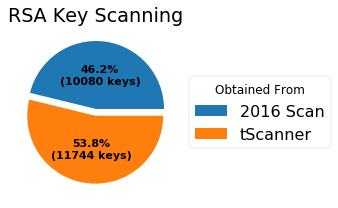

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style  

moduli_files = ["input.moduli", "tScanner.moduli"]
vuln_files = ["input.moduli.vuln", "tScanner.moduli.vuln"]

#style.use('seaborn-poster')

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

data = []
dataLabel = ["2016 Scan", "tScanner"]

for (modu, vuln) in zip(moduli_files, vuln_files):
    with open(modu, "rb") as f:
        lines = f.readlines()
        
    data.append(len(lines))    

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} keys)".format(pct, absolute)

size = .3
explode = (0.05,0.05)
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  pctdistance=0.5,
                                  textprops=dict(color="black"),
                                  explode=explode)

legend= plt.legend(wedges, dataLabel,
                   title="Obtained From",
                   loc="center left",
                   bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(legend.get_title(), fontsize="12")
plt.setp(autotexts, size=11, weight="bold")

ax.set_title("RSA Key Scanning")

plt.tight_layout()                                                     
plt.savefig('rsa_scan.png', dpi=160, format="png", transparent=True)                                                                                               
plt.show()                                                    

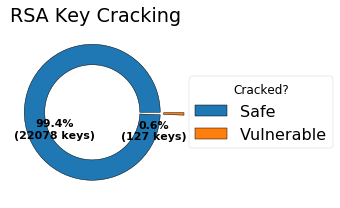

In [152]:
vuln_files = ["input.moduli.vuln", "tScanner.moduli.vuln"]

#style.use('seaborn-poster')

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

vuln_count = 0
dataLabel = ["Safe", "Vulnerable"]

data = [sum(data)]
for (modu, vuln) in zip(moduli_files, vuln_files):
    with open(vuln, "rb") as f:
        lines = f.readlines()
        
    vuln_count += len(lines)

data.append(vuln_count)

explode = (0.05,0.3)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "\n\n\n{:.1f}%\n({:d} keys)".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="black"),
                                  pctdistance=0.55,
                                  labeldistance=.7,
                                  explode=explode,
                                  wedgeprops=dict(width=size, edgecolor='black'))

legend= plt.legend(wedges, dataLabel,
                   title="Cracked?",
                   loc="center left",
                   bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(legend.get_title(), fontsize="12")
plt.setp(autotexts, size=11, weight="bold")

ax.set_title("RSA Key Cracking", color="black")

plt.tight_layout()                                                       
#plt.savefig('rsa_crack.png', dpi=160, format="png", transparent=True)                                                                                               
plt.show()                                                  

# Conclusion

## Insights about the data collected and processed
Interestingly, all of the keys I've collected recently are safe to batch-gcd, which is good! However I'm sure if I were able to scan more certificates I would be able to find a few keys that are not.

Out of all the keys processed through Tetanus, about .6% of the keys were actually weak to Batch-GCD. And unfortunately, all of them were from the 2016 dataset. People are securing their RSA keys and we should encourage that fact. I'm very sure that most of the major and important companies have their website certificates securied from this. And I know for sure that big certificate companies such as Let's Encrypt and CloudFlare have already solved this problem.

## Furthur Study
If I continue the study, I hope to collect more keys... Waaaay more keys. All the keys if possible. EVERY. SINGLE. KEY.

# Closing Thoughts
It is regrettable that I do not have enough time to collect more "up-to-date" certificates due to network and data storage limitations. Otherwise I might've received a more holistic dataset and be more conslusive about the research findings.